### OtoWorld
Welcome to OtoWorld, an interactive environment where agents must learn to listen in order to solve navigational tasks. OtoWorld is built on three open source libraries: OpenAI Gym for environment and agent interaction, Pyroomacoustics for ray-tracing and acoustics simulation, and \textit{nussl} for training deep computer audition models. OtoWorld can be easily extended to more complex environments and games. To solve one episode of OtoWorld, an agent must move towards each sounding source in the auditory scene and 'turn it off'. The agent receives no other input other than the current sound of the room. The sources are placed randomly within the room and can vary in number. The agent receives a reward for turning off a source.

### Important files to know
- audio_room

This is a package that holds all the source code for the environement. Here, you can read about the various configurable parameters for every room. 

- agent.py

This file contains the agents, including a perfect and random agent, which will be used to navigate a room. We recommend that you follow a similar code structure to the pre-defined agents. The reason why is because our code makes it as easy as possible for researchers to build agents by only completing four required functions (mentioned later).

- constants.py

This file contains some of the parameters used to penalize/reward an agent, build a trainable dataset, and more.

- datasets.py

- utils.py
- room_types.py

In [3]:
import sys
sys.path.append("../src")

import numpy as np
import audio_room
import room_types
from agent import PerfectAgent
import gym
import nussl
from datasets import BufferData
import constants
import utils

# sys.path.append("../notebooks")

### Creating your rooms
The rooms are created using the Pyroomacoustics library. Users can create simple Shoebox (rectangular) room or create more complicated n-shaped polygon rooms by specifying the location of the corners of the room. Through Pyroomacoustics, the environment supports the creation of rooms with different wall materials, energy absorption rates, temperatures, and humidity. Users can specify the number of sources which would then be spawned at random locations in the room. Additionally, every audio source has the same configurable threshold radius which is used to inform the agent that it is close enough to the audio source for it to be turned off. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Source locs [[0.6137236674566171, 4.589042148359943], [3.626776552956577, 1.548365761501881]]
Placing agent at [2.977706293793405, 4.338990777196511]

Starting a new Episode!


Validation Episode: False


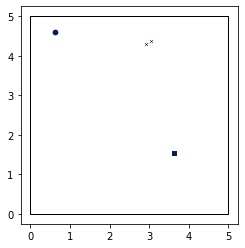

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


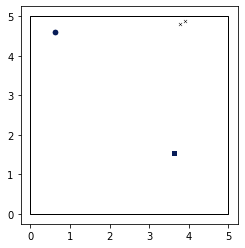

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


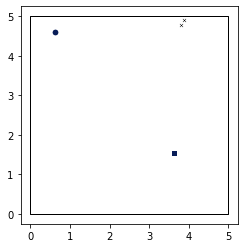

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


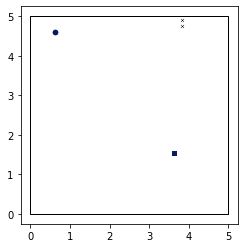

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


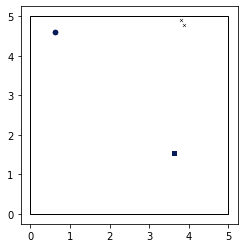

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


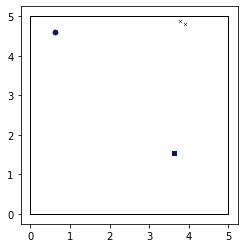

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


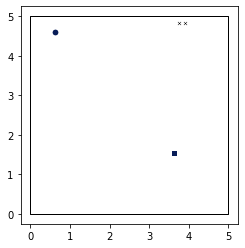

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  0


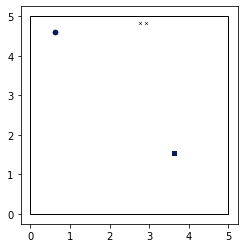

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  0


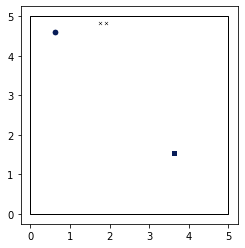

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  0


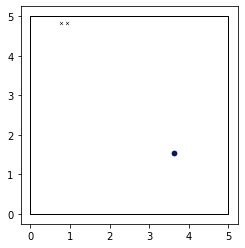

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In FIT. Received reward: 99.5 at step 9

My action is  1


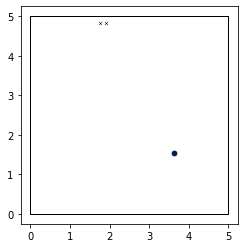

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  1


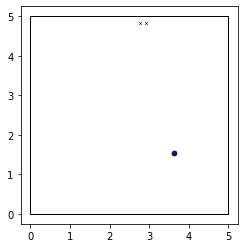

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


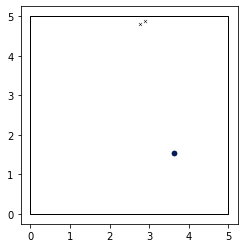

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


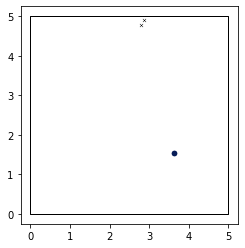

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


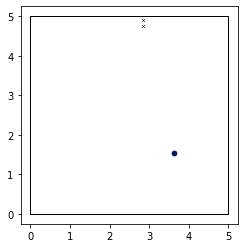

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  0


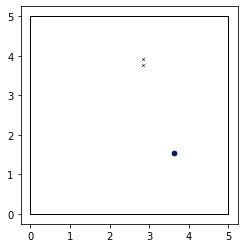

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  0


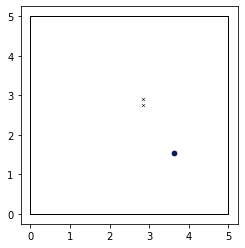

My action is  0
Source locs [[0.6691960105815231, 2.557015176124198], [3.549325051276881, 3.317484302466376]]
Placing agent at [4.126170642340446, 1.1741991080368126]
In FIT. Received reward: 99.5 at step 17

Mean ep Reward: 10.896671588930534


Episode Summary 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Episode: 0
- Won?: True
- Finished at step: 18
- Time taken:   23.621815 
- Steps/Second: 0.762008 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Source locs [[0.14234836853813793, 2.8611908040798664], [0.06055021740888522, 4.908416988653555]]
Placing agent at [1.2402542927963789, 0.3563503194383244]


--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 1034, in emit
    msg = self.format(record)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 880, in format
    return fmt.format(record)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 619, in format
    record.message = record.getMessage()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 380, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File

In [2]:
room = room_types.ShoeBox(x_length=5, y_length=5)
source_folders_dict = {"dry_recordings/dev/050" : 1, "dry_recordings/dev/051" : 1}
# Uncomment for Polygon Room
# room = room_types.Polygon(n=6, r=2, x_center=5, y_center=5)

# Set up the gym environment
env = gym.make(
    "audio-room-v0",
    source_folders_dict=source_folders_dict,
    room_config=room.generate(),
    corners=room.corners,
    max_order=10,
    step_size=1.0,
    num_sources=2,
    acceptable_radius=1.0
)

# discuss the dataset management
# create buffer data folders
utils.create_buffer_data_folders()
dataset = BufferData(folder=constants.DIR_DATASET_ITEMS, to_disk=True)

agent = PerfectAgent(env, dataset, show_room=True, play_audio=False, max_steps=100)
agent.fit()

Source locs [[7.296597401475397, 6.0], [5.0, 6.975171435119471]]
Placing agent at [2.798648991408121, 7.610475602749727]

Starting a new Episode!


Validation Episode: False


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


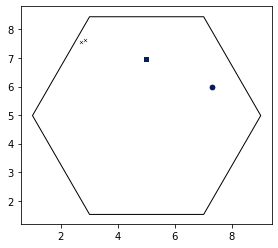

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


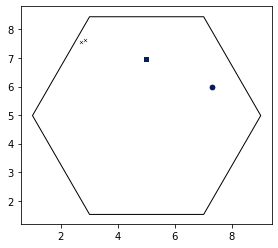

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


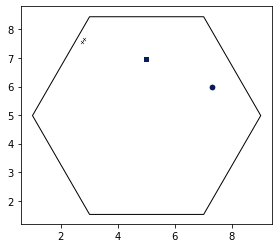

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


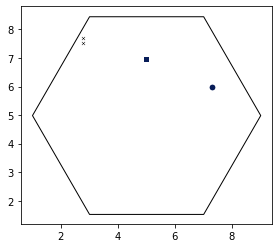

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


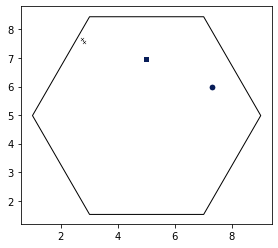

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


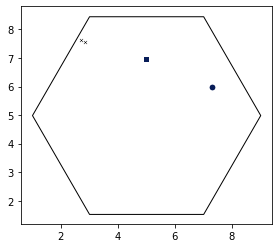

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


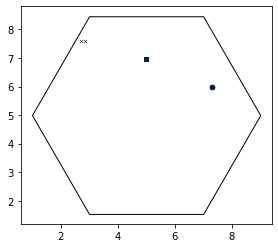

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  1


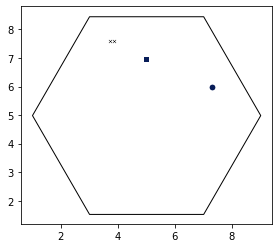

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  1


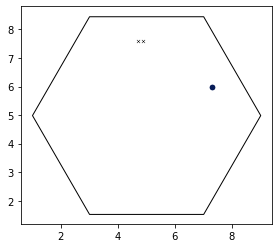

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In FIT. Received reward: 99.5 at step 8

My action is  1


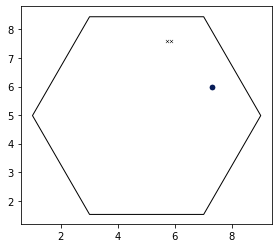

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  1


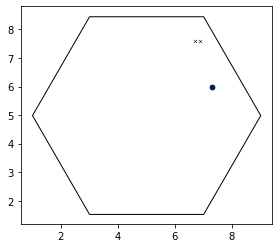

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


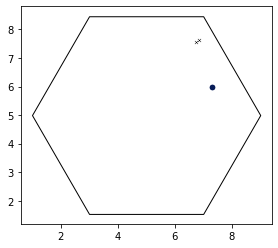

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


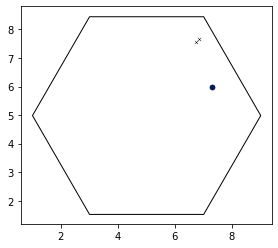

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


My action is  2


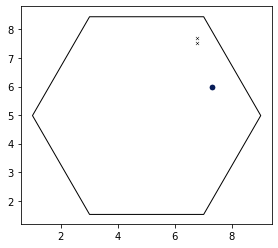

My action is  0
Source locs [[6.7410742989143815, 2.9843708545279233], [2.772354931288314, 7.286131480079636]]
Placing agent at [2.247810671256792, 2.4523579166883276]
In FIT. Received reward: 99.5 at step 14

Mean ep Reward: 13.214546074387366


Episode Summary 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Episode: 0
- Won?: True
- Finished at step: 15
- Time taken:   21.827314 
- Steps/Second: 0.687212 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Source locs [[6.734534481969475, 2.9956981497487014], [2.804633124435338, 7.802486969731735]]
Placing agent at [1.0065080753400064, 4.15549617739417]


--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 1034, in emit
    msg = self.format(record)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 880, in format
    return fmt.format(record)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 619, in format
    record.message = record.getMessage()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 380, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File

In [4]:
room = room_types.Polygon(n=6, r=2, x_center=5, y_center=5)
env = gym.make(
    "audio-room-v0",
    source_folders_dict=source_folders_dict,
    room_config=room.generate(),
    corners=room.corners,
    max_order=10,
    step_size=1.0,
    num_sources=2,
    acceptable_radius=1.0
)
utils.create_buffer_data_folders()
dataset = BufferData(folder=constants.DIR_DATASET_ITEMS, to_disk=True)

agent = PerfectAgent(env, dataset, show_room=True, play_audio=False, max_steps=100)
agent.fit()

### Logging information building a trainable dataset

### Creating your own agent
In order to create your own navigation agent, you must create a subclass of the AgentBase class found in the src/agent.py. There are four fundamental functions that must be implemented.
1. choose_action()
This function will decide what action you take from the action space given the current state.
2. update()
This function will update the q-network
3. update_stable_network()
This function will update the stable network
4. save_model()
This function periodically will save whatever parameters you find to be valuable.